In [ ]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

from explore_qml_data import get_smiles
from explore_qml_data import moltosvg
import explore_qml_data as eqd
import numpy as np
import os
import pandas as pd
import qml
import qml_interface as qmi
import analyse_atomic_data as aad

from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

In [ ]:
# labels
paths = qmi.wrapper_alch_data()
paths.remove('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001265/atomic_energies_with_mic.txt')
data, molecule_size = qmi.load_alchemy_data(paths)

atomisation_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomisation')
atomic_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomic')
alch_pot = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')

In [ ]:
atomic_database = pd.DataFrame(index=np.arange(molecule_size.sum()), columns=['mol_id', 'smiles', 'Z', 'atomic energy', 'atomisation energy', 'xyz_path'])
# make a database
index_database = 0
for i, p in enumerate(paths):
    data = np.loadtxt(p)
    # get smiles
    comp = p.split('/')[-2]
    xyz_path = f'/home/misa/datasets/qm9/{comp}.xyz'
    smiles = get_smiles(xyz_path)
    for d in data:
        atomic_database.at[index_database, 'xyz_path'] = xyz_path
        atomic_database.at[index_database, 'mol_id'] = i
        atomic_database.at[index_database, 'smiles'] = smiles
        atomic_database.at[index_database, 'Z'] = d[0]
        atomic_database.at[index_database, 'atomic energy'] = d[5]
        atomic_database.at[index_database, 'atomisation energy'] = d[6]
        
        index_database += 1

In [ ]:
nearest_neighbour = []
for i, p in enumerate(paths):
    # get smiles
    comp = p.split('/')[-2]
    xyz_path = f'/home/misa/datasets/qm9/{comp}.xyz'
    smiles = get_smiles(xyz_path)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    nearest_neighbour.extend(aad.get_charge_neighbours(mol))
atomic_database['charge NN'] = nearest_neighbour

### Find specific molecules

In [ ]:
smi = atomic_database.loc[(atomic_database['Z']==6), 'xyz_path']
for i,s in enumerate(smi):
    if i == 10 or i == 15:
        print(s)

In [ ]:
#ae_OH = np.array(atomic_database.loc[(atomic_database['smiles']=='CC(C)CCO') & (atomic_database['Z']==6), 'atomic energy'])

In [86]:
ae_OH = np.array([-37.025341125778674, -37.72615414645493, -41.39719232146205,
       -41.41755239475593, -40.51916525252558])

In [87]:
ae_CH3 = np.array([-36.9364, -37.6107,-41.2111, -40.9553, -39.3028])

In [ ]:
#atomic_database.loc[(atomic_database['smiles']=='CCCC(C)C') & (atomic_database['Z']==6), 'atomic energy']

In [ ]:
x_barOH = np.arange(5)
x_barCH3 = np.arange(5)

#plt.bar(x_barOH, ae_OH)
plt.rcParams['font.size'] = 20
plt.bar(x_barCH3, ae_OH-ae_CH3)
plt.xlabel('position')
plt.ylabel(r'$\Delta E_I$')

In [ ]:
eqd.mol_with_atom_index(Chem.MolFromSmiles('CC(C)CCO'))

In [ ]:
eqd.mol_with_atom_index(Chem.MolFromSmiles('CCCC(C)C'))

In [ ]:
# is the decay proportional to 1/r?

In [ ]:
#print(atomic_database.loc[(atomic_database['smiles']=='CC(C)CCO'), 'mol_id']) mol_id = 2
#print(atomic_database.loc[(atomic_database['smiles']=='CCCC(C)C'), 'mol_id']) mol_id = 3

In [ ]:
paths[2]

In [ ]:
paths[3]

In [71]:
data_OH = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000272/atomic_energies_with_mic.txt')
data_CH3 = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000274/atomic_energies_with_mic.txt')

In [149]:
def sort_energies(coords, energies, hetero_index, nuc_charges):
    pos_X = coords[hetero_index]
    sorted_energies = []
    for pos, e, n in zip(coords, energies, nuc_charges):
        if n > 1:
            d = np.linalg.norm(pos-pos_X)
            sorted_energies.append([d, e])
    sorted_energies.sort()
    return(np.array(sorted_energies))

In [102]:
dist_en_OH = sort_energies(data_OH[:, 1:4], data_OH[:, 5], 5, data_OH[:,0])
dist_en_CH3 = sort_energies(data_CH3[:, 1:4], data_CH3[:, 5], 0, data_CH3[:,0])

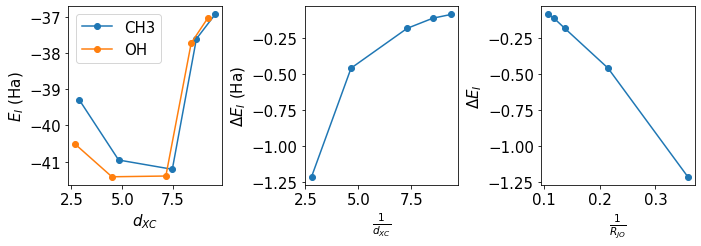

In [121]:
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,3)

ax[0].plot(dist_en_CH3[1:,0], dist_en_CH3[1:,1], '-o', label='CH3')
ax[0].plot(dist_en_OH[1:,0], dist_en_OH[1:,1], '-o', label='OH')
ax[0].set_xlabel(r'$d_{XC}$')
ax[0].set_ylabel(r'$E_I$ (Ha)')
ax[0].legend()

dE = (dist_en_OH[1:,1] - dist_en_CH3[1:,1])
ax[1].plot((0.5*(dist_en_OH[1:,0]+dist_en_CH3[1:,0])), dE, '-o')
ax[1].set_xlabel(r'$\frac{1}{d_{XC}}$')
ax[1].set_ylabel(r'$\Delta E_I$ (Ha)')

ax[2].plot(1/((0.5*(dist_en_OH[1:,0]+dist_en_CH3[1:,0]))), dE, '-o')
ax[2].set_xlabel(r'$\frac{1}{d_{XC}}$')
ax[2].set_ylabel(r'$\Delta E_I$ (Ha)')

plt.xlabel(r'$\frac{1}{R_{JO}}$')
plt.ylabel(r'$\Delta E_I$')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [91]:
pos_CH3

array([20.927788, 23.842126, 19.473032])

### Rotation of molecules
Rotate the molecules such that the plane formed by the heteroatom and the closest carbon atoms connected to it (at least if not the whole heavy atom framwork) lie in the x-y plane. Then shift the molecules such that the carbon atom closest to the heteroatom sits on a grid point of the electron density grid.

In [ ]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

import explore_qml_data as eqd
import analyse_atomic_data as aad
import qml_interface as qmi
from parse_density_files import CUBE
import alchemy_tools2 as at

import numpy as np
import ase.units
import os
import pandas as pd
import qml
from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

In [ ]:
rot_z = lambda alpha: np.array([[np.cos(alpha), -np.sin(alpha), 0], [np.sin(alpha), np.cos(alpha), 0], [0, 0, 1]])
rot_x = lambda alpha: np.array([[1, 0, 0], [0, np.cos(alpha), -np.sin(alpha)], [0, np.sin(alpha), np.cos(alpha)]])

def get_rotation_matrix(a, b, c):
    """
    rotation matrix such that plane formed by a, b, c is in orthogonal to z-axis
    """
    v1 = a - b
    v2 = a -c
    
    # normal vector of plane through O, C1, C2
    n = np.cross(v1, v2)/np.linalg.norm(np.cross(v1, v2))
    z = np.array([0,0,1])

    # normal vector should be parallel to unit vector along z-axix

    # align with y-axis (rotate around z-axis)
    n_xy = n.copy() # projection of n on x-y-plane
    n_xy[2] = 0.0
    n_xy = n_xy/np.linalg.norm(n_xy)
    y = np.array([0,1,0])
    angle_ny = np.arccos(np.dot(n_xy, y))

    n_y = (rot_z(angle_ny)@(n.T)).T # lying in z-y plane
    n_y = n_y/np.linalg.norm(n_y)

    # align with z-axis
    z = np.array([0,0,1])
    angle_z = np.arccos(np.dot(n_y, z))
    n_rotated = (rot_x(angle_z)@(n_y.T)).T # lying in z-y plane

    rotation_matrix = rot_x(angle_z)@rot_z(angle_ny)
    
    return(rotation_matrix)

In [ ]:
cube = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000274/cube-files/ve_38.cube')

In [ ]:
data_OH = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000272/atomic_energies_with_mic.txt')
data_CH3 = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000274/atomic_energies_with_mic.txt')
mol = data_CH3
coords = mol[:,1:4]*ase.units.Bohr

#mol = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_000930.xyz')
#mol = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_000949.xyz')

#coords = mol.coordinates


In [ ]:
rotation_matrix = get_rotation_matrix(coords[0], coords[1], coords[2])
coords_rotated = (rotation_matrix@coords.T).T
coords_rotated = coords_rotated + np.array([8, 24, 20])

In [ ]:
coords_rotated

In [ ]:
grid = np.array(cube.get_grid())*ase.units.Bohr

dist = []
for g, c in zip(grid, coords_rotated[4]):
    dist.append(g.flatten()-c)
#grid[0].shape
dist = np.array(dist)

In [ ]:
dist2 = np.reshape(np.sqrt((dist*dist).sum(axis=0)), (175, 175, 175))
np.where(dist2 == np.amin(dist2))

In [ ]:
dist2[np.where(dist2 == np.amin(dist2))]

In [ ]:
shift = np.array([grid[0][np.where(dist2 == np.amin(dist2))][0], grid[1][np.where(dist2 == np.amin(dist2))][0], grid[2][np.where(dist2 == np.amin(dist2))][0]]) - coords_rotated[4]

In [ ]:
new_coords = (coords_rotated + shift)

In [ ]:
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/hitp')

import prepare_calculations

In [ ]:
selected_molecules = ['/home/misa/datasets/qm9/dsgdb9nsd_000949.xyz']
for s in selected_molecules:
    path_to_xyz = s#'/home/misa/datasets/qm9/dsgdb9nsd_000930.xyz'
    compound = s.split('.')[0].split('/')[-1]
    compound_path = f'/home/misa/projects/Atomic-Energies/data/ueg_reference/density_slices/{compound}/'
    lambda_values = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

    comp = qml.Compound(xyz=path_to_xyz)
    atomsymbols = comp.atomtypes
    nuc_charges = comp.nuclear_charges

    # calculation parameters (independent of lambda value)
    num_ve = eqd.get_num_val_elec(nuc_charges) # get number of ve
    boxsize = prepare_calculations.get_boxsize(num_ve) # get boxsize
    num_gpts_lower, num_gpts_higher = prepare_calculations.get_gpts(num_ve) # get gridpoints
    num_gpts = num_gpts_higher

    # shift molecule to center of the box
    #coords_initial = comp.coordinates
    coords = new_coords #eqd.shift2center(coords_initial, np.array([boxsize, boxsize, boxsize])/2)

    # get correct lambda value
    for lam_val in lambda_values:
        new_lambda, scaled_ve = prepare_calculations.get_lambda(lam_val, num_ve)
        # scaled_ve is number of electrons added from pseudopotential file, the remaining electrons must be added in form of a negative charge
        charge = scaled_ve - num_ve # write input

        # create directory if necessary
        if scaled_ve < 10:
            scaled_ve_str = '0'+str(scaled_ve)
        else:
            scaled_ve_str = str(scaled_ve)
        work_dir = os.path.join(compound_path, f've_{scaled_ve_str}/')
        os.makedirs(work_dir, exist_ok=True)

        # generate input file
        input_path = os.path.join(work_dir, 'run.inp')
        prepare_calculations.write_input(atomsymbols, charge, coords, num_gpts, boxsize, input_path, '/home/misa/projects/Atomic-Energies/data/cpmd_params_template.inp', debug = False)

        # generate pp-files
        prepare_calculations.write_pp_files_compound(comp, new_lambda, work_dir, pp_dir='/home/misa/software/PP_LIBRARY/', pp_type='_SG_LDA')

### Analyse effect of heteroatom on the atomic properties

In [20]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

import explore_qml_data as eqd
import analyse_atomic_data as aad
import qml_interface as qmi
from parse_density_files import CUBE
import alchemy_tools2 as at
import utils_qm as uqm

import numpy as np
import ase.units
import os
import glob
import pandas as pd
import qml
from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

In [21]:
def calculate_integrand_I(pos_nuc, density, meshgrid, h_matrix):
    distance_nuc_grid = at.distance_MIC2(pos_nuc, meshgrid, h_matrix) # calculate distance of gpts to nucleus with MIC
    return(-density/distance_nuc_grid)

def find_plane(z_pos, grid):
    #assert np.where(np.isclose(grid[2][0][0], z_pos))[0].shape[0] == 1
    #z_index = np.where(np.isclose(grid[2][0][0], z_pos))[0][0]
    
    z_index = np.where(np.abs(grid[2][0][0] - z_pos) == np.amin(np.abs(grid[2][0][0] - z_pos)))[0][0]
    return(z_index)

def get_coords(atoms, par):
    coords = dict()

    for i, at in enumerate(atoms):
        if at[0] > 1:
            if par['hetero_pos'] == i:
                coords['X'] = at[1:4]
            else:
                coords[f'C{i}'] = at[1:4]
    return(coords)

def get_integrands(cube_38, density, hetero_pos, num_heavy_atoms):
    """
    returns \tilde{rho}/|r - R_I| for all heavy atoms as a dictionary, keys are sorted by increasing distance to heteroatom
    """
    atoms = []
    for i in range(num_heavy_atoms):
        dist_X = np.linalg.norm(cube_38.atoms[hetero_pos][1:4] - cube_38.atoms[i][1:4])
        atoms.append([dist_X, cube_38.atoms[i][1:4]])
        atoms.sort()
        keys = ['X'] + [f'C{i}' for i in range(1, num_heavy_atoms)]
        integrand_dict = dict(zip(keys, atoms))

        h_matrix = np.array([cube_38.X*cube_38.NX, cube_38.Y*cube_38.NY, cube_38.Z*cube_38.NZ])#*ase.units.Bohr
        meshgrid = cube_38.get_grid()
        for k in integrand_dict.keys():
            pos_nuc = integrand_dict[k][1]
            integrand = calculate_integrand_I(pos_nuc, density, meshgrid, h_matrix)
            integrand_dict[k].append(integrand)
    return(integrand_dict)

def load_data(paths):
    """
    paths: paths to cube files in increasing order in lambda
    load cube files
    """
    cube_0 = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/ueg/ve_00.cube')
    mean = (cube_0.data_scaled).mean()
    cube_0.data_scaled[:] = mean

    cube_8 = CUBE(paths[0])
    cube_15 = CUBE(paths[1])
    cube_23 = CUBE(paths[2])
    cube_30 = CUBE(paths[3])
    cube_38 = CUBE(paths[4])

    densities = [cube_0.data_scaled, cube_8.data_scaled, cube_15.data_scaled, cube_23.data_scaled, cube_30.data_scaled, cube_38.data_scaled]
    lam_vals = np.array([0, 8, 15, 23, 30, 38])/38
    return(cube_38, densities, lam_vals)

### Determine parameters

In [26]:
#cube_38 = CUBE('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000272/cube-files/ve_38.cube')

cube_38 = CUBE('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000949/cube-files/ve_36.cube')

In [27]:
print(len(cube_38.atoms), '\n')
for atom in cube_38.atoms:
    if atom[0] == 1:
        element = 'H'
    elif atom[0] == 6:
        element = 'C'
    elif atom[0] == 7:
        element = 'N'
    elif atom[0] == 8:
        element = 'O'
    print(f'{element}\t{atom[1]*ase.units.Bohr}\t{atom[2]*ase.units.Bohr}\t{atom[3]*ase.units.Bohr}')

13 

O	8.581879023775247	9.851805372990091	10.057156822967075
C	9.942870949978813	9.942870949978813	10.057156822967075
C	10.61395761309956	11.166616004027748	10.057156822967075
C	12.00653930206494	11.192748891394235	10.057178519232709
C	12.73586456309429	10.007344313782278	10.057213974105816
C	12.056698422322656	8.788803717599238	10.057221382586762
C	10.667731542882635	8.749330272754438	10.057186456890864
H	8.208735005518262	10.739238730168916	10.056848312653315
H	10.04757183615213	12.09461767370003	10.057145181068442
H	12.519417854543416	12.149052545819101	10.057174285815023
H	13.819657061910988	10.030849836298314	10.057235670371448
H	12.613870165679748	7.857559779157833	10.057243078852396
H	10.126251491350395	7.810224877672896	10.05718010676434


In [ ]:
# define input parameters
par_dsgdb9nsd_000274 = {'hetero_pos': 0, 'index': 1, 'num_heavy_atoms': 6, 'save_dir':'/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000274'}
par_dsgdb9nsd_000272 = {'hetero_pos': 5, 'index': 4, 'num_heavy_atoms': 6, 'save_dir':'/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000272'}
par_dsgdb9nsd_000930 = {'hetero_pos': 0, 'index': 1, 'num_heavy_atoms': 7, 'save_dir':'/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000930'}
par_dsgdb9nsd_000940 = {'hetero_pos': 0, 'index': 1, 'num_heavy_atoms': 7, 'save_dir':'/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000940'}
par_dsgdb9nsd_000949 = {'hetero_pos': 0, 'index': 1, 'num_heavy_atoms': 7, 'save_dir':'/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000949'}


par = par_dsgdb9nsd_000949
paths = glob.glob(os.path.join(par['save_dir'], 'cube-files/*'))
paths.sort()
hetero_pos = par['hetero_pos']
index = par['index']
num_heavy_atoms = par['num_heavy_atoms']

# load data
print('Loading data...', flush = True)
cube_38, densities, lam_vals = load_data(paths)

# density at lambda = 1
rho = densities[-1]
# lambda averaged density
rho_tilde = at.integrate_lambda_density(densities, lam_vals)

# integrand \tilde{\rho}/|r - R_I|
print('Calculating integrand...', flush = True)

integrand_dict = get_integrands(cube_38, rho_tilde, hetero_pos, num_heavy_atoms)
#uqm.save_obj(integrand_dict, '/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000274/coords')
print('Done', flush = True)

# find plane in which carbon atoms
z_pos = cube_38.atoms[index][3]
grid = cube_38.get_grid()
z_index = find_plane(z_pos, grid)

# select slices
rho_slice = rho[:,:,z_index]
rho_tilde_slice = rho_tilde[:,:,z_index]
integrand_slices = dict()
for k in integrand_dict.keys():
    integrand_slices[k] = integrand_dict[k][2][:,:,z_index] # slice of \tilde{\rho}/|r - R_I|
    
# save data
coords = get_coords(cube_38.atoms, par)
sp = os.path.join(par['save_dir'], 'coords')
uqm.save_obj(coords, sp)

np.save(os.path.join(par['save_dir'], 'rho_slice'), rho_slice)
np.save(os.path.join(par['save_dir'], 'rho_tilde_slice'), rho_tilde_slice)
for k in integrand_slices.keys():
    arr = integrand_slices[k]
    np.save(os.path.join(par['save_dir'], f'{k}_integrand_slice'), arr)
    
print('All Done', flush = True)

### Plot results

In [1]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

import numpy as np
from matplotlib import pyplot as plt
import utils_qm as uqm
import ase.units

import glob
import os

In [2]:
def plot_rho(rho, coords, xlims, ylims):
    plt.rcParams['font.size'] = 20
    x = np.linspace(0, 20, 175)
    plt.contour(x, x, rho)
    plt.ylim(ylims)
    plt.xlim(xlims)
    for k in coords.keys():
        #x_coord = coords[k][1][0]*ase.units.Bohr
        #y_coord = coords[k][1][1]*ase.units.Bohr
        x_coord = coords[k][0]*ase.units.Bohr
        y_coord = coords[k][1]*ase.units.Bohr
        plt.scatter(y_coord, x_coord, s = 20, color='tab:red')
    plt.xlabel('y (Ang)')
    plt.ylabel('x (Ang)')
    
def load_results(path):

    integr_paths = glob.glob(os.path.join(path, 'C*_integrand_slice.npy'))
    integr_paths.sort()
    integrands = []
    keys = []
    for p in integr_paths:
        keys.append(p.split('/')[-1].split('_')[0])
        integrands.append(np.load(p))
    
    results = dict(zip(keys, integrands))
    
    rho = np.load(os.path.join(path, 'rho_slice.npy'))
    rho_tilde = np.load(os.path.join(path, 'rho_tilde_slice.npy'))
    results['rho'] = rho
    results['rho_tilde'] = rho_tilde
    
    return(results)

### Alkanes

In [68]:
results_272 = load_results('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000272')
results_272['C1'][np.where(np.amin(results_272['C1']) == results_272['C1'])] = 0
coords_272 = uqm.load_obj('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000272/coords')

results_274 = load_results('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000274')
results_274['C1'][np.where(np.amin(results_274['C1']) == results_274['C1'])] = 0
coords_274 = uqm.load_obj('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000274/coords')

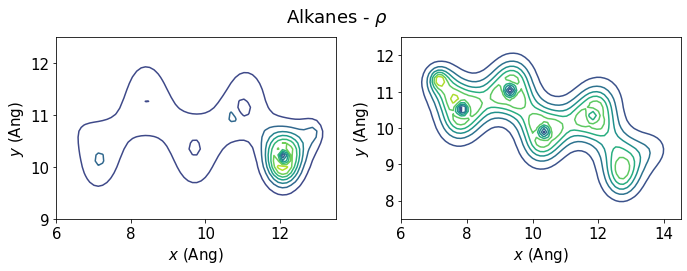

In [50]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [10,4]

fig, ax = plt.subplots(1,2)
x = np.linspace(0, 20, 175)
ax[0].contour(x, x, results_272['rho'])
ax[0].set_xlim(6,13.5)
ax[0].set_ylim(9,12.5)
ax[0].set_xlabel('$x$ (Ang)')
ax[0].set_ylabel('$y$ (Ang)')

ax[1].contour(x, x, results_274['rho'])
ax[1].set_xlim(6,14.5)
ax[1].set_ylim(7.5,12.5)
ax[1].set_xlabel('$x$ (Ang)')
ax[1].set_ylabel('$y$ (Ang)')
fig.suptitle(r'Alkanes - $\rho$')
#fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

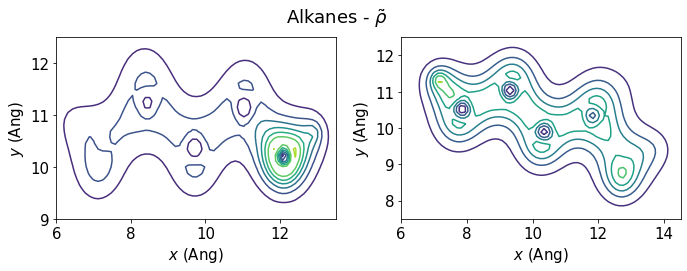

In [49]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [10,4]
fig, ax = plt.subplots(1,2)
x = np.linspace(0, 20, 175)
ax[0].contour(x, x, results_272['rho_tilde'])
ax[0].set_xlim(6,13.5)
ax[0].set_ylim(9,12.5)
ax[0].set_xlabel('$x$ (Ang)')
ax[0].set_ylabel('$y$ (Ang)')

ax[1].contour(x, x, results_274['rho_tilde'])
ax[1].set_xlim(6,14.5)
ax[1].set_ylim(7.5,12.5)
ax[1].set_xlabel('$x$ (Ang)')
ax[1].set_ylabel('$y$ (Ang)')
fig.suptitle(r'Alkanes - $\tilde{\rho}$')
#fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

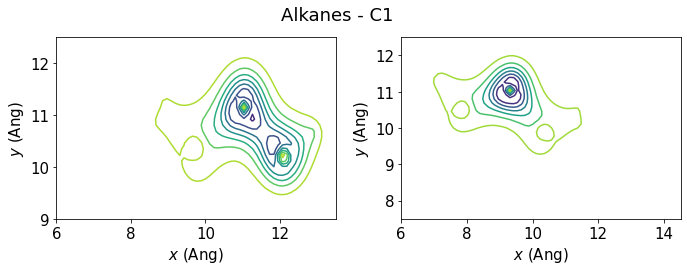

In [70]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [10,4]
fig, ax = plt.subplots(1,2)
x = np.linspace(0, 20, 175)
ax[0].contour(x, x, results_272['C1'])
ax[0].set_xlim(6,13.5)
ax[0].set_ylim(9,12.5)
ax[0].set_xlabel('$x$ (Ang)')
ax[0].set_ylabel('$y$ (Ang)')

ax[1].contour(x, x, results_274['C1'])
ax[1].set_xlim(6,14.5)
ax[1].set_ylim(7.5,12.5)
ax[1].set_xlabel('$x$ (Ang)')
ax[1].set_ylabel('$y$ (Ang)')
fig.suptitle(r'Alkanes - C1')
#fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Aromates

In [157]:
results_930 = load_results('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000930')
coords_930 = uqm.load_obj('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000930/coords')
data_930 = np.loadtxt('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000930/atomic_energies_with_mic.txt')
dist_en_930 = sort_energies(data_930[:, 1:4], data_930[:, 5], 0, data_930[:,0])


results_940 = load_results('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000940')
coords_940 = uqm.load_obj('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000940/coords')
data_940 = np.loadtxt('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000940/atomic_energies_with_mic.txt')
dist_en_940 = sort_energies(data_940[:, 1:4], data_940[:, 5], 0, data_940[:,0])

results_949 = load_results('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000949')
coords_949 = uqm.load_obj('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000949/coords')
data_949 = np.loadtxt('/home/misa/projects/Atomic-Energies/data/ueg_reference/effect_heteroatoms/dsgdb9nsd_000949/atomic_energies_with_mic.txt')
dist_en_949 = sort_energies(data_949[:, 1:4], data_949[:, 5], 0, data_949[:,0])

In [164]:
dist_en_949

array([[  0.        , -55.37465399],
       [  2.57765291, -42.30588616],
       [  4.45840505, -39.79384375],
       [  4.57378936, -39.83077243],
       [  6.86684518, -38.56788092],
       [  6.9500899 , -38.57894809],
       [  7.85539585, -38.23098163]])

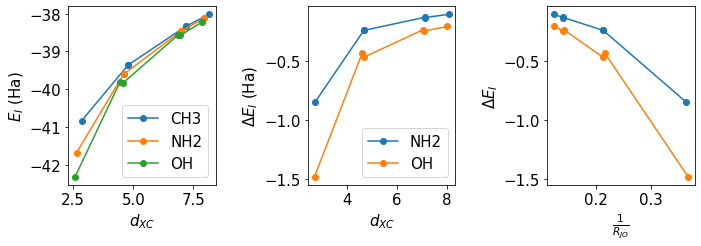

In [168]:
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,3)

ax[0].plot(dist_en_930[1:,0], dist_en_930[1:,1], '-o', label='CH3')
ax[0].plot(dist_en_940[1:,0], dist_en_940[1:,1], '-o', label='NH2')
ax[0].plot(dist_en_949[1:,0], dist_en_949[1:,1], '-o', label='OH')

ax[0].set_xlabel(r'$d_{XC}$')
ax[0].set_ylabel(r'$E_I$ (Ha)')
ax[0].legend()

dENH2 = -(dist_en_930[1:,1] - dist_en_940[1:,1])
dENOH = -(dist_en_930[1:,1] - dist_en_949[1:,1])

ax[1].plot((0.5*(dist_en_930[1:,0]+dist_en_940[1:,0])), dENH2, '-o', label='NH2')
ax[1].plot((0.5*(dist_en_930[1:,0]+dist_en_949[1:,0])), dENOH, '-o', label='OH')

ax[1].set_xlabel(r'$d_{XC}$')
ax[1].set_ylabel(r'$\Delta E_I$ (Ha)')
ax[1].legend()

ax[2].plot(1/((0.5*(dist_en_930[1:,0]+dist_en_940[1:,0]))), dENH2, '-o', label='NH2')
ax[2].plot(1/((0.5*(dist_en_930[1:,0]+dist_en_949[1:,0]))), dENOH, '-o', label='OH')

ax[2].set_xlabel(r'$\frac{1}{d_{XC}}$')
ax[2].set_ylabel(r'$\Delta E_I$ (Ha)')

plt.xlabel(r'$\frac{1}{R_{JO}}$')
plt.ylabel(r'$\Delta E_I$')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

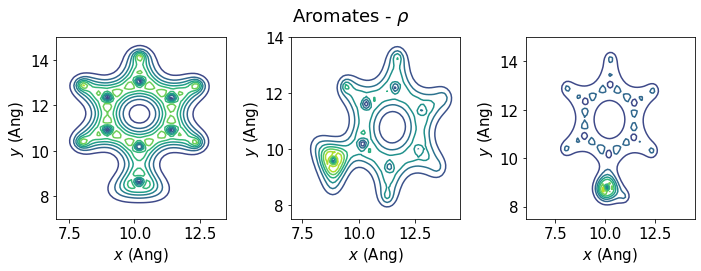

In [130]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [10,4]

fig, ax = plt.subplots(1,3)
x = np.linspace(0, 20, 175)
ax[0].contour(x, x, results_930['rho'])
ax[0].set_xlim(7,13.5)
ax[0].set_ylim(7,15)
ax[0].set_xlabel('$x$ (Ang)')
ax[0].set_ylabel('$y$ (Ang)')

ax[1].contour(x, x, results_940['rho'])
ax[1].set_xlim(7,14.5)
ax[1].set_ylim(7.5,14)
ax[1].set_xlabel('$x$ (Ang)')
ax[1].set_ylabel('$y$ (Ang)')

ax[2].contour(x, x, results_949['rho'])
ax[2].set_xlim(6,14.5)
ax[2].set_ylim(7.5,15)
ax[2].set_xlabel('$x$ (Ang)')
ax[2].set_ylabel('$y$ (Ang)')

fig.suptitle(r'Aromates - $\rho$')
#fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

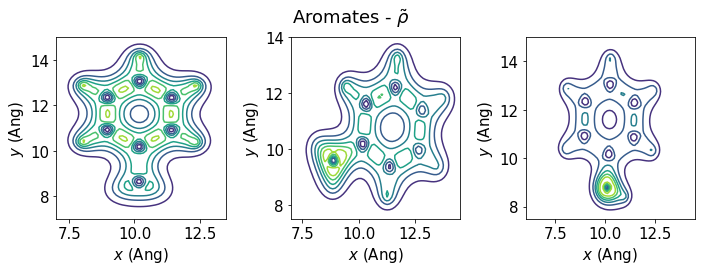

In [133]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [10,4]

fig, ax = plt.subplots(1,3)
x = np.linspace(0, 20, 175)
ax[0].contour(x, x, results_930['rho_tilde'])
ax[0].set_xlim(7,13.5)
ax[0].set_ylim(7,15)
ax[0].set_xlabel('$x$ (Ang)')
ax[0].set_ylabel('$y$ (Ang)')

ax[1].contour(x, x, results_940['rho_tilde'])
ax[1].set_xlim(7,14.5)
ax[1].set_ylim(7.5,14)
ax[1].set_xlabel('$x$ (Ang)')
ax[1].set_ylabel('$y$ (Ang)')

ax[2].contour(x, x, results_949['rho_tilde'])
ax[2].set_xlim(6,14.5)
ax[2].set_ylim(7.5,15)
ax[2].set_xlabel('$x$ (Ang)')
ax[2].set_ylabel('$y$ (Ang)')

fig.suptitle(r'Aromates - $\tilde{\rho}$')
#fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

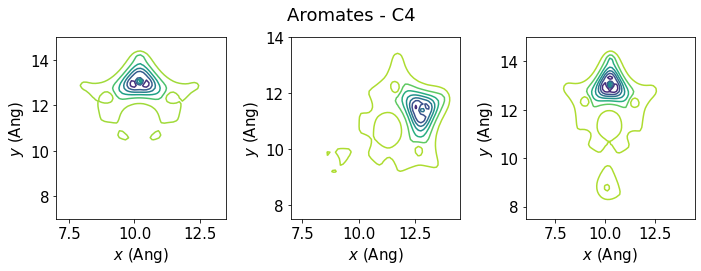

In [148]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [10,4]

fig, ax = plt.subplots(1,3)
x = np.linspace(0, 20, 175)
ax[0].contour(x, x, results_930['C6'])
ax[0].set_xlim(7,13.5)
ax[0].set_ylim(7,15)
ax[0].set_xlabel('$x$ (Ang)')
ax[0].set_ylabel('$y$ (Ang)')

ax[1].contour(x, x, results_940['C6'])
ax[1].set_xlim(7,14.5)
ax[1].set_ylim(7.5,14)
ax[1].set_xlabel('$x$ (Ang)')
ax[1].set_ylabel('$y$ (Ang)')

ax[2].contour(x, x, results_949['C6'])
ax[2].set_xlim(6,14.5)
ax[2].set_ylim(7.5,15)
ax[2].set_xlabel('$x$ (Ang)')
ax[2].set_ylabel('$y$ (Ang)')

fig.suptitle(r'Aromates - C4')
#fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
def get_integrals_box(density, gpts, nuclei, radii):
    """
    return value of integrals for different vdW for one boxsize
    """
    estat_int = []
    for r in radii:
        estat_int.append( get_integral_radius(density, gpts, nuclei, r) )
    return(np.array(estat_int))
        
def get_integral_radius(density, gpts, nuclei, radius):
    """
    return value of integral for one multiple of the vdW radii
    """
    
    # set density to zero outside of integration radius
    density_bound = generate_bound_density(density, nuclei, radius, gpts)

    # calculate integral for new density
    estat_int = at.calculate_atomic_energies(density_bound, nuclei, gpts, h_matrix)
    
    return(estat_int)
    
def generate_bound_density(density, nuclei, radius, gpts):
    # reshape into vectors
    density_flattened = density.flatten()
    gpts_flattened = at.meshgrid2vector(gpts)
    
    # get density grid points lying within the weighted vdW radii
    all_idc_in = get_all_idc_in(nuclei, radius, gpts_flattened)
    # get indices of all gridpoints as flattened 1D-array
    all_idc = np.arange(len(density_flattened))
     # get density grid points lying out of the weighted vdW radii
    all_idc_out = at.get_all_idc_out(all_idc_in, all_idc)
    
    # set density out of weighted vdW radii to zero
    density_flattened[all_idc_out] = 0.0
    # reshape flattened density to grid
    density_bound = density_flattened.reshape((density.shape))
    return(density_bound)
        
def get_all_idc_in(nuclei, radius, gpts_flattened):
    all_idc_in = []
    for n in nuclei:
        #r_vdW = lookup_vdW(n[0])
        all_idc_in.append(at.get_idc_rvdW(np.array([n[1:4]]), radius, gpts_flattened))
    return(all_idc_in)
   
from ase.units import Bohr
def lookup_vdW(Z, unit = 'Bohr'):
    """
    return van der Waals radius for element
    from Bondi J. Phys. Chem 68, 1964
    """
    
    if Z == 1:
        r_w = 1.2
    elif Z == 6:
        r_w = 1.7
    elif Z == 7:
        r_w = 1.55
    elif Z == 8:
        r_w = 1.52
    else:
        raise Exception("r_w not implemented for Z = {}".format(Z))
        
    if unit == 'Bohr':
        r_w /= Bohr
    return(r_w)

def get_radial_props(atoms, density, gpts, radii):
    dens_sum = []
    for r in radii:
        tmp = []
        for n in atoms*ase.units.Bohr:
            dens = generate_bound_density(density, [n], r, gpts)
            tmp.append(dens.sum())
        dens_sum.append(tmp)
    dens_sum = np.array(dens_sum)
    return(dens_sum)

In [ ]:
# nucleus3 = cube_272.atoms[0]*ase.units.Bohr
# nucleus3 = cube_272.atoms[1]*ase.units.Bohr
# nucleus3 = cube_272.atoms[2]*ase.units.Bohr
# nucleus3 = cube_272.atoms[3]*ase.units.Bohr
# nucleus4 = cube_272.atoms[4]*ase.units.Bohr
# nucleus5 = cube_272.atoms[5]*ase.units.Bohr

radii = np.linspace(0, 10, 15)

#rho_272 = cube_272.data_scaled
gpts = cube_38.get_grid()
for i, g in enumerate(gpts):
    tmp = g*ase.units.Bohr
    gpts[i] = tmp

densr = get_radial_props(cube_38.atoms[:6], cube_38.data_scaled, gpts, radii)
densrt = get_radial_props(cube_38.atoms[:6], rho_tilde, gpts, radii)

radii = np.linspace(0, 20, 15)/ase.units.Bohr

integrand = get_integrand(cube_38.atoms[:6], rho_tilde, cube_38.get_grid(), radii, h_matrix)

In [ ]:
np.save('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/densr_000274.npy', densr)
np.save('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/denstr_000274.npy', densrt)
np.save('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/integrand_000274.npy', integrand)

In [ ]:
d272 = np.load('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/rho_000272.npy')
d272t = np.load('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/rho_tilde_000272.npy')
d272int = np.load('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/integrand_000272.npy')

d274 = np.load('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/densr_000274.npy')
d274t = np.load('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/denstr_000274.npy')
d274int = np.load('/home/misa/projects/Atomic-Energies/data/ueg_reference/atomic_properties/integrand_000274.npy')



In [ ]:
for i, l in zip(range(d272.shape[1]-1), [0,1,2,3,4]):
    plt.plot(radii[:-4], d272[:-4, i], label=l)
plt.legend()

In [ ]:
for i in range(d272t.shape[1]-1):
    plt.plot(radii[:], d272t[:, i], label=i)
plt.legend()

In [ ]:
for i in range(d274t.shape[1]-1):
    plt.plot(radii[:], d274t[:, i], label=i)
plt.legend()

In [ ]:
for i in range(d272int.shape[1]):
    plt.plot(radii[:]*ase.units.Bohr, d272int[:, i], '-o',label=i)
plt.legend()

In [ ]:
for i in range(d274int.shape[1]):
    plt.plot(radii[:]*ase.units.Bohr, d274int[:, i], '-o',label=i)
plt.legend()

In [ ]:
d274int[-1]

In [ ]:
d272int[-1]

In [ ]:

for d, dt, i, index in zip(d272[:, :5], d272t[:, :5], d272int[:, :5], index_272):
    

In [ ]:
index_272 = [4, 3, 1, 2, 0]

In [ ]:
d272[:, :5]

In [ ]:
plt.plot(radii, d272[:, 4] - d274[:, 1])

In [ ]:
smi = atomic_database.loc[(atomic_database['Z']==6), 'smiles']
mols = []
for s in smi:
    mols.append(Chem.MolFromSmiles(s))
print(len(smi), flush=True)
Chem.Draw.MolsToGridImage(mols,molsPerRow=6,subImgSize=(200,200))

In [ ]:
smi = atomic_database.loc[(atomic_database['Z']==7), 'smiles']
mols = []
for s in smi:
    mols.append(Chem.MolFromSmiles(s))
print(len(smi), flush=True)
Chem.Draw.MolsToGridImage(mols,molsPerRow=6,subImgSize=(200,200))